In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import backtrader as bt
idx = pd.IndexSlice
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfullerJJ
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from datetime import datetime

In [111]:
nifty_meta = pd.read_csv('data/ind_nifty100list.csv')
market_data_pre = pd.read_csv('data/nifty100.csv')
market_data_pre.set_index('Date')
market_data_pre.rename(columns = {'Adj Close':'Market Close'}, inplace = True)
market_data_pre = market_data_pre.iloc[:, [0,5]]
z = market_data_pre.set_index('Date')
z

,Market Close
Date,
2010-01-04,5153.549805
2010-01-05,5203.799805
2010-01-06,5214.000000
2010-01-07,5191.700195
2010-01-08,5175.750000
...,...
2020-12-23,13725.549805
2020-12-24,13862.099609
2020-12-28,13986.700195


In [3]:
tickers = list(nifty_meta[nifty_meta.Industry == 'Financial Services'].Symbol)
print(tickers)

['AXISBANK', 'BAJFINANCE', 'BAJAJFINSV', 'BAJAJHLDNG', 'BANDHANBNK', 'BANKBARODA', 'CHOLAFIN', 'HDFCAMC', 'HDFCBANK', 'HDFCLIFE', 'HDFC', 'ICICIBANK', 'ICICIGI', 'ICICIPRULI', 'INDUSINDBK', 'KOTAKBANK', 'MUTHOOTFIN', 'PAYTM', 'PEL', 'PNB', 'SBICARD', 'SBILIFE', 'SBIN']


In [4]:
prices = pd.read_csv('data/prices.csv', index_col=['ticker','date'])
prices.head(2)

open        high         low       close
ticker   date                                                      
AXISBANK 2010-01-04  198.779999  199.990005  197.619995  140.712021
         2010-01-05  199.600006  204.000000  199.139999  143.647934

In [5]:
minobs = 2520
nobs = prices.groupby(level='ticker').size()
nobs

ticker
AXISBANK      2572
BAJAJFINSV    2571
BAJAJHLDNG    2572
BAJFINANCE    2572
BANDHANBNK     541
BANKBARODA    2572
GICRE          646
HDFC          2572
HDFCAMC        450
HDFCBANK      2572
HDFCLIFE       629
IBULHSGFIN    1691
ICICIBANK     2572
ICICIGI        664
ICICIPRULI     910
INDUSINDBK    2572
KOTAKBANK     2572
L&TFH         2168
NIACL          633
PEL           2572
PFC           2572
PNB           2572
SBILIFE        661
SBIN          2572
SRTRANSFIN    2573
dtype: int64

In [83]:
keep = nobs[nobs > minobs].index
prices = prices.loc[idx[keep,:], :]      #multiindex slicing using idx; keeps all the 'keep' tickers (first level of indes slicing) then keeps all the dates of the kept tickers using ' : ' right after keep (second level slicing), and keeps all the columns using ' : ' again for columns loc
prices

open        high         low       close
ticker     date                                                      
AXISBANK   2010-01-04  198.779999  199.990005  197.619995  140.712021
           2010-01-05  199.600006  204.000000  199.139999  143.647934
           2010-01-06  204.000000  205.740005  198.509995  141.236801
           2010-01-07  199.289993  201.199997  197.820007  142.236725
           2010-01-08  200.600006  203.979996  199.270004  144.094727
...                           ...         ...         ...         ...
SRTRANSFIN 2020-06-09  636.900024  650.950012  613.000000  619.599976
           2020-06-10  622.599976  641.700012  612.099976  635.000000
           2020-06-11  615.250000  676.000000  615.250000  637.900024
           2020-06-12  615.000000  693.700012  606.000000  684.400024
           2020-06-15  690.000000  707.549988  664.000000  672.799988

[38580 rows x 4 columns]

In [7]:
TICKERS = prices.index.get_level_values('ticker').unique()   #final ticker values after filtering for 10+ yrs data
print(TICKERS)

Index(['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA',
       'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL',
       'PFC', 'PNB', 'SBIN', 'SRTRANSFIN'],
      dtype='object', name='ticker')


In [91]:
close = prices.unstack('ticker')['close']
close = close.dropna()

ticker,AXISBANK,BAJAJFINSV,BAJAJHLDNG,BAJFINANCE,BANKBARODA,HDFC,HDFCBANK,ICICIBANK,INDUSINDBK,KOTAKBANK,PEL,PFC,PNB,SBIN,SRTRANSFIN
date,,,,,,,,,,,,,,,
2010-01-04,140.712021,347.934143,494.222076,16.031584,51.206989,429.764343,134.245209,85.319977,133.753540,202.426041,252.234650,61.325417,84.943443,95.066895,421.881561
2010-01-05,143.647934,348.708527,498.012665,15.924150,52.686508,431.226868,134.363205,86.130264,133.613098,204.430389,253.638733,62.669540,86.255913,95.102180,424.757904


In [9]:
len(close.index)

2571

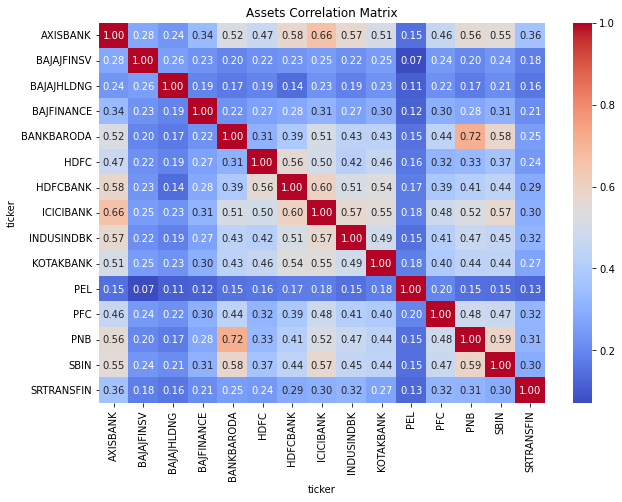

In [10]:
train_close, test_close = train_test_split(close, test_size = 0.5, shuffle = False)                   # train test split to train on which are cointegrated pairs from train data and then backtest on test data 
fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax = ax, cmap ='coolwarm', annot = True, fmt =".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('images/chart1', dpi = 300)


In [212]:
log_prices = np.log(train_close)
log_ret = log_prices.diff().dropna(axis = 0)
log_market_data = np.log(z)
log_market_ret = log_market_data.diff().dropna()
returns_data = pd.merge(log_ret, log_market_ret, left_index = True, right_index = True)

In [213]:
def find_coint_pairs(data):                       #finding cointegrated pairs
    n = data.shape[1]
    p_table = np.ones((n,n))
    pairs = []
    keys = data.keys()
    
    for i in range (n):
        for j in range (i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            p_table[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
                
    return p_table, pairs

In [214]:
def find_obs_spread(pair):
    obs = log_ret[pair[0]] - log_ret[pair[1]]
    return obs

In [284]:
def em_fit(y, r, init_params, num_iter=150, x_0=0, R_0=0.1):
    '''
    run Shumway Stoffer algorithm with given initial values
    
    Args:
        y (numpy.ndarray): input time series (difference in log returns)
        r (numpy.ndarray): input exogenous data (market return)
        init_params (dict): initial parameters for EM algorithm
        num_iter (int): maximum number of iterations for EM algorithm
        x_0 (float): initial value of state for Kalman filter
        R_0 (float): initial value of variance for Kalman filter
            
    Returns:
        dict: parameters (each parameter (key) is a list of all values from initial value until convergence)
        int: iteration at which the algorithm converged 
    '''
    
    N = len(y)
    A,B,C,D,G_sq,H_sq = [np.zeros((num_iter,)) for _ in range(6)]
    A[0],B[0],C[0],D[0],G_sq[0],H_sq[0] = (init_params['A'], init_params['B'], init_params['C'], 
                                     init_params['D'], init_params['G']**2, init_params['H']**2)
    
    # run algorithm for num_iter iterations
    for i in range(1,num_iter):
        
        # define matrices
        F = np.array([[A[i-1],0],[0,0]]) # state transition matrix
        G = np.array([[B[i-1],0],[0,1]]) # control matrix
        H = np.array([[1,D[i-1]]]) # observation matrix
        Q = np.array([[G_sq[i-1],0],[0,0.0001]]) # process noise matrix
        
        # define state and uncertainty
        z_0 = np.array([[x_0, r[0]]]).T
        P_0 = np.array([[R_0,0],[0,0]])

        # run Kalman filter
        z_pred = np.zeros([N,2,1])
        P_pred = np.zeros([N,2,2])

        for k in range(0,N):

            # predict
            if k==0:
                z_hat = F @ z_0 + G @ np.array([[1,r[k]]]).T
                P_hat = F @ P_0 @ F.T + Q
            else:
                z_hat = F @ z_pred[k-1] + G @ np.array([[1,r[k]]]).T
                P_hat = F @ P_pred[k-1] @ F.T + Q
            
            # update
            K = P_hat @ H.T @ np.linalg.inv(H @ P_hat @ H.T + H_sq[i-1])
            z_pred[k] = z_hat + K @ (y[k] - H @ z_hat)
            P_pred[k] = (np.eye(2) - K @ H) @ P_hat @ (np.eye(2) - K @ H).T + K * H_sq[i-1] @ K.T
            

        # run Kalman smoother
        z_N = np.zeros([N,2,1]) # smoothed state
        P_N = np.zeros([N,2,2]) # smoothed covariance
        J = np.zeros([N,2,2]) # backwards Kalman gain
        z_N[-1] = z_pred[-1] # initial smoothed state
        P_N[-1] = P_pred[-1] # initial smoothed covariance

        for k in range(N-2,-1,-1):
            J[k] = P_pred[k] @ F.T @ np.linalg.inv(F @ P_pred[k] @ F.T + Q)
            z_N[k] = z_pred[k] + J[k] @ (z_N[k+1] - (F @ z_pred[k] + G @ np.array([[1,r[k]]]).T))
            P_N[k] = P_pred[k] + J[k] @ (P_N[k+1] - (F @ P_pred[k] @ F.T + Q)) @ J[k].T
            
            
        # extract only spread and its variance
        x_N = z_N[:,0].flatten()
        R_N = P_N[:,0,0]
        K = K[0]
        
        # EM-algo
        P_11 = np.sum(R_N[1:] + x_N[1:]**2)
        P_00 = np.sum(R_N[:-1] + x_N[:-1]**2)
        # compute P_10
        sigma_kN = np.zeros(N)
        sigma_kN[-1] = A[i-1] * (1 - K) * P_pred[-1,0,0]
        for k in range(N-2,-1,-1):
            sigma_kN[k] = J[k,0,0] * P_pred[k+1,0,0] + J[k+1,0,0]*J[k,0,0] * (sigma_kN[k+1] - A[i-1] * P_pred[k+1,0,0])
        P_10 = np.sum(sigma_kN[1:] + x_N[1:] * x_N[:-1])
        
        # update parameters
        A[i] = (P_10 - 1/N * x_N[1:].sum() * x_N[:-1].sum()) / (P_00 - 1/N * (x_N[:-1]).sum() * (x_N[:-1]).sum())
        #A[i] = true_params['A']
        B[i] = (x_N[1:].sum() - A[i] * x_N[:-1].sum()) * 1/N
        #B[i] = true_params['B']
        C[i] = (((y[1:] * x_N[1:]).sum() - (y[1:]*r[1:]).sum() / (r[1:]**2).sum() * (x_N[1:]*r[1:]).sum()) / 
                (P_11 - (x_N[1:]*r[1:]).sum() / (r[1:]**2).sum() * x_N[1:]*r[1:]).sum())
        D[i] = ((y[1:] - x_N[1:]) * r[1:]).sum() / (r[1:]**2).sum()
        #D[i] = true_params['D']
        G_sq[i] = 1/N * (P_11 + A[i]**2 * P_00 + N*B[i]**2 - 2*P_10*A[i] - 2*(B[i]*x_N[1:]).sum() + 
                       (2*A[i]*x_N[:-1]*B[i]).sum())
        #G_sq[i] = true_params['G']**2
        H_sq[i] = 1/N * (R_N[1:].sum() + ((y[1:] - x_N[1:] - D[i]*r[1:])**2).sum())
        #H_sq[i] = true_params['H']**2
            
        # check convergence       
        S = abs(G_sq[i]-G_sq[i-1]) + abs(H_sq[i]-H_sq[i-1]) + abs(A[i]-A[i-1]) + abs(B[i]-B[i-1]) + abs(D[i]-D[i-1])
        if S<0.001:
            print('Converged at ', i)
            break
        
#    return {'A':A, 'B':B, 'C':C, 'D':D, 'G':np.sqrt(G_sq), 'H':np.sqrt(H_sq)}, i
    return A[i], B[i], C[i], D[i], np.sqrt(G_sq[i]), np.sqrt(H_sq[i]), i


In [285]:

def generate_data(params, N=100):
    
    v = np.random.normal(size=N)
    w = np.random.normal(size=N)
    
    prm = ['A','B','C','D','G','H']
    A,B,C,D,G,H = [params[x] for x in prm]

    # assume r is lognormal
    r = np.random.lognormal(sigma=0.05, size=N) - 1
    
    x = np.zeros(N)
    y = np.zeros(N)

    for i in range(1,len(x)):
        x[i] = A*x[i-1] + B + G*v[i]
        y[i] = x[i] + D*r[i] + H*w[i]
        
    return x, y, r

[('AXISBANK', 'PEL'), ('AXISBANK', 'SRTRANSFIN'), ('BAJAJFINSV', 'HDFCBANK'), ('BAJAJFINSV', 'INDUSINDBK'), ('BAJAJFINSV', 'KOTAKBANK'), ('BAJAJHLDNG', 'ICICIBANK'), ('BAJAJHLDNG', 'SBIN'), ('BAJFINANCE', 'KOTAKBANK'), ('BANKBARODA', 'ICICIBANK'), ('BANKBARODA', 'SBIN'), ('BANKBARODA', 'SRTRANSFIN'), ('ICICIBANK', 'PEL'), ('ICICIBANK', 'SBIN'), ('INDUSINDBK', 'KOTAKBANK'), ('INDUSINDBK', 'PEL'), ('KOTAKBANK', 'PEL'), ('PEL', 'SBIN')]


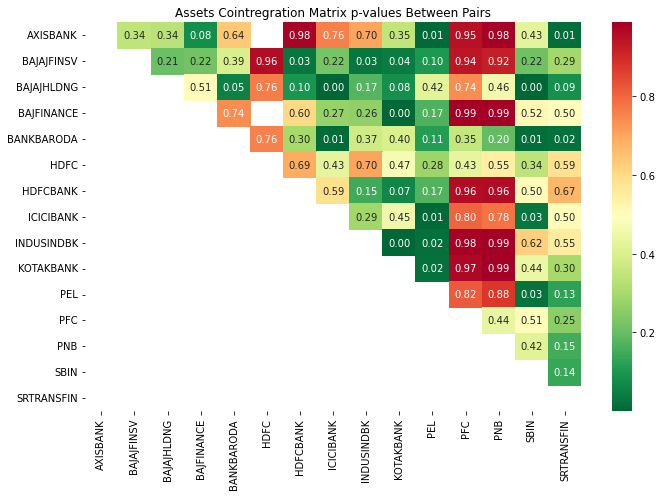

In [217]:
#calculate p-values and plot as a heatmap

pvalues, pairs = find_coint_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('images/chart2', dpi=300)

In [286]:
parameters_df1 = pd.DataFrame(columns = ['Pairs', 'A','B','C','D','G','H'])
init_params = {'A':0.5, 'B':0, 'C':1, 'D':0, 'G':0.1, 'H':0.1}
max_iter = 1000


for pair in pairs:
    s1 = pair[0]
    s2 = pair[1]
    tup = (s1, s2)
    print(f'Processing pair {pair} ...')
    
    
    spread = returns_data[s1] - returns_data[s2]
    market_train = returns_data['Market Close']
    #parameters, i = em_fit(spread, market_train, init_params, num_iter = max_iter)
    A, B, C, D, G, H, i = em_fit(spread, market_train, init_params, num_iter = max_iter)
#     for x in [A, B, C, D, G, H]:
#         x = x.tolist()
#     i = int(i)
#    a = A[i], b = B[i], c = C[i], d = D[i], g = G[i], h = H[i]
    
    if i < max_iter - 1: # if converged
        #parameters_df.loc[pair] = [parameters[p][i] for p in parameters_df.columns]
#        x = {'Pairs': pair, 'A': A[i], 'B': B[i], 'C': C[i], 'D': D[i], 'G': G[i], 'H':H[i]}
#        x = {'Pairs': pair, 'A': A, 'B': B, 'C': C, 'D': D, 'G': G, 'H':H}
        x = [pair, A, B, C, D, G, H]
        parameters_df1.loc[len(parameters_df1)] = x
        
    

Processing pair ('AXISBANK', 'PEL') ...
Converged at  31
Processing pair ('AXISBANK', 'SRTRANSFIN') ...
Converged at  12
Processing pair ('BAJAJFINSV', 'HDFCBANK') ...
Converged at  11
Processing pair ('BAJAJFINSV', 'INDUSINDBK') ...
Converged at  27
Processing pair ('BAJAJFINSV', 'KOTAKBANK') ...
Converged at  14
Processing pair ('BAJAJHLDNG', 'ICICIBANK') ...
Converged at  17
Processing pair ('BAJAJHLDNG', 'SBIN') ...
Converged at  14
Processing pair ('BAJFINANCE', 'KOTAKBANK') ...
Converged at  8
Processing pair ('BANKBARODA', 'ICICIBANK') ...
Converged at  22
Processing pair ('BANKBARODA', 'SBIN') ...
Converged at  16
Processing pair ('BANKBARODA', 'SRTRANSFIN') ...
Converged at  15
Processing pair ('ICICIBANK', 'PEL') ...
Converged at  13
Processing pair ('ICICIBANK', 'SBIN') ...
Converged at  15
Processing pair ('INDUSINDBK', 'KOTAKBANK') ...
Converged at  93
Processing pair ('INDUSINDBK', 'PEL') ...
Converged at  50
Processing pair ('KOTAKBANK', 'PEL') ...
Converged at  48
Proce

In [287]:
parameters_df1

,Pairs,A,B,C,D,G,H
0,"(AXISBANK, PEL)",-0.058949,-0.000405,0.000660,1.042978,0.010315,0.023783
1,"(AXISBANK, SRTRANSFIN)",0.000547,-0.000029,0.000733,0.595059,0.016318,0.019980
2,"(BAJAJFINSV, HDFCBANK)",0.009893,0.000235,0.000759,-0.322973,0.016383,0.017512
3,"(BAJAJFINSV, INDUSINDBK)",-0.057035,0.000005,0.000742,-0.604412,0.014337,0.023328
4,"(BAJAJFINSV, KOTAKBANK)",0.030934,0.000401,0.000756,-0.452612,0.016128,0.019283
5,"(BAJAJHLDNG, ICICIBANK)",-0.021671,0.000247,0.000577,-1.105481,0.010099,0.018867
6,"(BAJAJHLDNG, SBIN)",-0.006987,0.000226,0.000656,-0.890704,0.012859,0.019808
7,"(BAJFINANCE, KOTAKBANK)",0.025662,0.001656,0.000690,-0.321067,0.018139,0.018613
8,"(BANKBARODA, ICICIBANK)",-0.053084,0.000131,0.000763,-0.345579,0.013113,0.017104
9,"(BANKBARODA, SBIN)",0.051325,0.000099,0.000783,-0.132391,0.014081,0.014553


In [288]:
# select only pairs with positive A
good_pairs_df = parameters_df1[parameters_df1['A']>0]

# calculate parameters of Vasicek process
good_pairs_df['log_A'] = np.log(good_pairs_df['A'].astype(float))
good_pairs_df[r'$\theta$'] = good_pairs_df['B'] / (1 - good_pairs_df['A'])
good_pairs_df[r'$\kappa$'] = -good_pairs_df['log_A']
good_pairs_df[r'$\sigma$'] = np.sqrt((good_pairs_df['G']**2 * 2 * good_pairs_df[r'$\kappa$'] / 
                                     (1 - np.exp(-2 * good_pairs_df[r'$\kappa$']))).astype(float))

<ipython-input-288-417a60c597e8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_pairs_df['log_A'] = np.log(good_pairs_df['A'].astype(float))
<ipython-input-288-417a60c597e8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_pairs_df[r'$\theta$'] = good_pairs_df['B'] / (1 - good_pairs_df['A'])
<ipython-input-288-417a60c597e8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [344]:
good_pairs_df1 = good_pairs_df.set_index('Pairs')

In [345]:
good_pairs_df1

,A,B,C,D,G,H,log_A,$\theta$,$\kappa$,$\sigma$
Pairs,,,,,,,,,,
"(AXISBANK, SRTRANSFIN)",0.000547,-0.000029,0.000733,0.595059,0.016318,0.019980,-7.510750,-0.000029,7.510750,0.063245
"(BAJAJFINSV, HDFCBANK)",0.009893,0.000235,0.000759,-0.322973,0.016383,0.017512,-4.615898,0.000238,4.615898,0.049780
"(BAJAJFINSV, KOTAKBANK)",0.030934,0.000401,0.000756,-0.452612,0.016128,0.019283,-3.475906,0.000413,3.475906,0.042543
"(BAJFINANCE, KOTAKBANK)",0.025662,0.001656,0.000690,-0.321067,0.018139,0.018613,-3.662726,0.001700,3.662726,0.049111
"(BANKBARODA, SBIN)",0.051325,0.000099,0.000783,-0.132391,0.014081,0.014553,-2.969570,0.000104,2.969570,0.034361
"(ICICIBANK, PEL)",0.002106,-0.000439,0.000621,1.087072,0.013663,0.021335,-6.163014,-0.000440,6.163014,0.047970
"(ICICIBANK, SBIN)",0.037806,-0.000018,0.000776,0.215908,0.013413,0.014507,-3.275294,-0.000019,3.275294,0.034354
"(PEL, SBIN)",0.016269,0.000414,0.000683,-0.871849,0.016563,0.021755,-4.118472,0.000421,4.118472,0.047541


In [499]:
#arranging according to highest kappa (to indicate fastest speed of mean reversion) and making sure
#every stock in the selected pairs occurs only once
#selecting top 5 pairs

selected_pairs = []
selected_stocks = []

good_pairs_df1.sort_values(by=r'$\kappa$', ascending=False).index
v = good_pairs_df1.index
z = list(v)

for pair in z:
    s1 = pair[0]
    s2 = pair[1]
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_pairs.append(pair)
        selected_stocks.append(s1)
        selected_stocks.append(s2)
    
    if len(selected_pairs)>=5:
        break

In [500]:
class PandasData(bt.feed.DataBase):
    params = (
        ('datetime', 'date'),
        ('open', None),
        ('high', None),
        ('low', None),
        ('close', 'close'),
        ('volume', None),
        ('openinterest', None)
        )

In [558]:
class em_fit_converter(bt.Indicator):
    lines = ('A','B','C','D','G','H','k')
    params = (('period', 50),)
    W = 50 #trailing window used for em_fit in everyday calculation
    max_iter = 1000
    
    
    def next(self):
        n = len(self.datas) - 1
        self.lines.A[0], self.lines.B[0], self.lines.C[0],
        self.lines.D[0], self.lines.G[0], self.lines.H[0],
        self.lines.k[0] = em_fit(self.spread.get(size = self.p.period), self.market_rets.get(size = self.p.period), 
                                 init_params, num_iter = max_iter)


In [559]:

class testStrategy(bt.Strategy):
    
    
    def __init__(self):
        
        n = len(self.datas) - 1                           #will be used to point to log market returns (last data feed)
        
        for i,d in enumerate(self.datas[0:n]):                 #data order in self.datas same as that of stocks listed in the pairs array
            if i%2 == 0:                                  #for even indices in self.datas aka first stock in every pair
                self.spread = self.datas[i].close - self.datas[i+1].close
                self.market_rets = self.datas[n].close
                self.lines.values = em_fit_converter(self.datas[i])
                self.theta = self.values.lines.B/(1 - self.values.lines.A)
                self.true_spread = self.spread - self.values.lines.D * self.datas[n].close
                self.cum_sum_true_spread = sum(self.true_spread.get(size = 5))
                
    def next(self):
        
        for i,d in enumerate(self.datas[0:n]):
            if i%2 == 0:
                if self.cum_sum_spread < self.theta:
                    self.buy(data = d, size = 10)
                    self.sell(data = self.datas[i+1], size = 10)
                    
                if self.cum_sum_spread > self.theta:
                    self.sell(data = d, size = 10)
                    self.buy(data = self.datas[i+1], size = 10)
                    
        

In [560]:
# class testStrategy(bt.Strategy):
    
    
#     def __init__(self):
#         n = len(self.datas[0])
#         y = len(pairs)*2
#         self.bolls = [None]*y                             #will store line objects of bollinger bands for each ratio
#         self.pair_size = [None]*y                         #will store size of position taken in each pair
        
#         for i,d in enumerate(self.datas):                 #data order in self.datas same as that of stocks listed in the pairs array
#             if i%2 == 0:                                  #for even indices in self.datas aka first stock in every pair
#                 self.price_ratio = self.datas[i]/self.datas[i+1]
#                 self.boll = bt.ind.BollingerBands(self.price_ratio, period = 252, devfactor = 2)          #creates line object of Z-score for price ratio of each pair and stores it in the datafeed of the first stock in the pair
#                 self.bolls[i] = self.boll                 #creates an array of line objects of price ratios for each pair with alternate None values
                
#     def next(self):
#         for i,d in enumerate(self.datas):
#             if (i%2 == 0):
#                 z = self.bolls[i]
#                 if (self.getposition(d).size == 0):               #if not in market
#                     if self.broker.getvalue() != 0:               #if value of portfolio not zero
#                         perc_port_val_S1 = self.broker.getposition(d).size * self.broker.getposition(d).price/ self.broker.getvalue()                               #percentage portfolio value of that stock
#                         perc_port_val_S2 = self.broker.getposition(self.datas[i+1]).size * self.broker.getposition(self.datas[i+1]).price/ self.broker.getvalue()
#                         x = math.floor(.64*self.broker.getvalue()/(self.datas[i].close + self.datas[i+1].close))
                        
#                     elif self.broker.getvalue() == 0:                                         #if value of portfolio zero
#                         perc_port_val_S1 = 0
#                         perc_port_val_S2 = 0
#                         x = math.floor(.06*self.broker.getcash()/(self.datas[i].close + self.getposition(self.datas[i+1]).price))
                   
#                     if (perc_port_val_S1 < 0.25 and perc_port_val_S2 < 0.25):                     #if total investment in both the stocks of that pair over all the pairs is less than 25% portfolio value then
                        
#     #objective is that we purchase shares for each stock that will result in 6% of resulting total portfolio value of pair from purchase
#     #we perform a simple calculation ( P1*x + P2*x = 0.06(P1*x + P2*x + current portfolio value) ) 
#     #which shows us that the size of the position that needs to be taken (x) so that the percentage value of the pair is 6% of future portfolio value is
#     #x = 0.064*current portfolio value / (price_1 + price_2)
#     #if current portfolio value is zero we can simply use sizer
    
                       
        
#                         if (self.price_ratio >= z.lines.top):

#                             self.buy(data = d, size = x)                                                    #short S1
#                             self.sell(data = self.datas[i+1], size = x)                                     #long S2
#                             self.pair_size[i] = x
                            
#                         elif (self.price_ratio <= z.lines.bot):
#                             self.sell(data = d, size = x)                                                    #long S1
#                             self.buy(data = self.datas[i+1], size = x)                                       #short S2
#                             self.pair_size[i] = x

#                 else:                                           #if in the market
#                     if (self.getposition(d).size < 0):          #if S1 short which implies S2 long
#                         if (self.price_ratio <= (z.lines.top)*0.3):         #arbitrary condition set which implies conversion back to mean
#                             self.buy(data = d, size = self.pair_size[i])
#                             self.sell(data = self.datas[i+1], size = self.pair_size[i])

#                     else:                                       #if S1 long which implies S2 short
#                         if (self.price_ratio >= (z.lines.bot)*0.3):
#                             self.sell(data = d, size = self.pair_size[i])
#                             self.buy(data = self.datas[i+1], size = self.pair_size[i])
                        
                

In [561]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(1000000.0)

In [562]:
y = log_ret
lr = y.reset_index()
S1 = lr.filter(['date','BAJAJFINSV' ], axis=1)
lmr = log_market_ret.reset_index()

In [563]:
S1 = lr.filter(['date', 'AXISBANK'], axis=1)
S1['date'] = pd.to_datetime(S1['date'], format = '%Y-%m-%d' )
S1.rename(columns = {'AXISBANK':'close'}, inplace = True)
S1.set_index('date')

ticker,close
date,
2010-01-05,0.020650
2010-01-06,-0.016927
2010-01-07,0.007055
2010-01-08,0.012978
2010-01-11,0.032395
...,...
2015-03-13,-0.024436
2015-03-16,-0.002459
2015-03-17,0.020023


In [564]:
for i in selected_pairs:
    S1 = lr.filter(['date', i[0]], axis=1)
    S1['date'] = pd.to_datetime(S1['date'] )
    S1.rename(columns = {i[0]:'close'}, inplace = True)
    S1_ = S1.set_index('date')
    S2 = lr.filter(['date', i[1]], axis=1)
    S2['date'] = pd.to_datetime(S2['date'] )
    S2.rename(columns = {i[1]:'close'}, inplace = True)
    S2_ = S2.set_index('date') 
    data1 = bt.feeds.PandasData(dataname = S1_)
    data2 = bt.feeds.PandasData(dataname = S2_)
    cerebro.adddata(data1)
    cerebro.adddata(data2)


In [565]:
lmr['Date'] = pd.to_datetime(lmr['Date'] )
data1 = bt.feeds.PandasData(dataname = lmr, datetime = 'Date')
cerebro.adddata(data1)

In [566]:
cerebro.addstrategy(testStrategy)
cerebro.addindicator(em_fit_converter)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'sharpe')
test = cerebro.run(runonce = False)
# cerebro.plot(volume = False)

AttributeError: 'Lines_LineSeries_LineIterator_DataAccessor_Indicat' object has no attribute 'spread'

In [23]:
cerebro.broker.getvalue()

3429070.8195152283

<IPython.core.display.Javascript object>


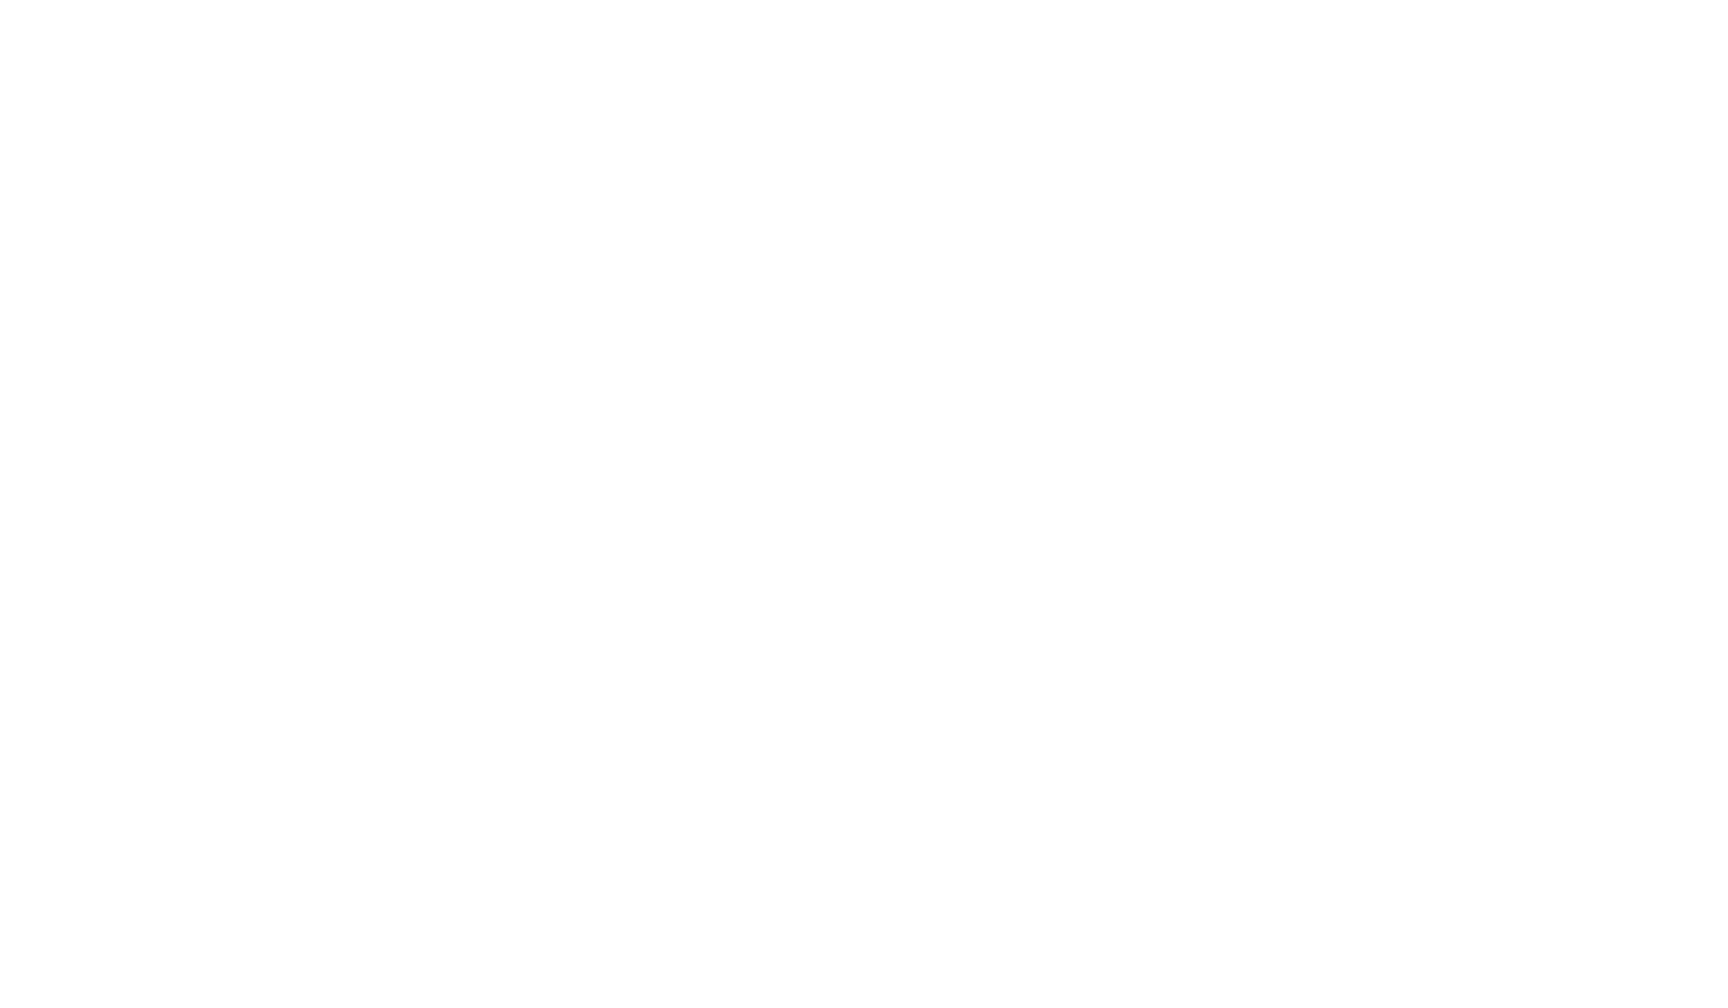

[[<Figure size 864x504 with 206 Axes>]]

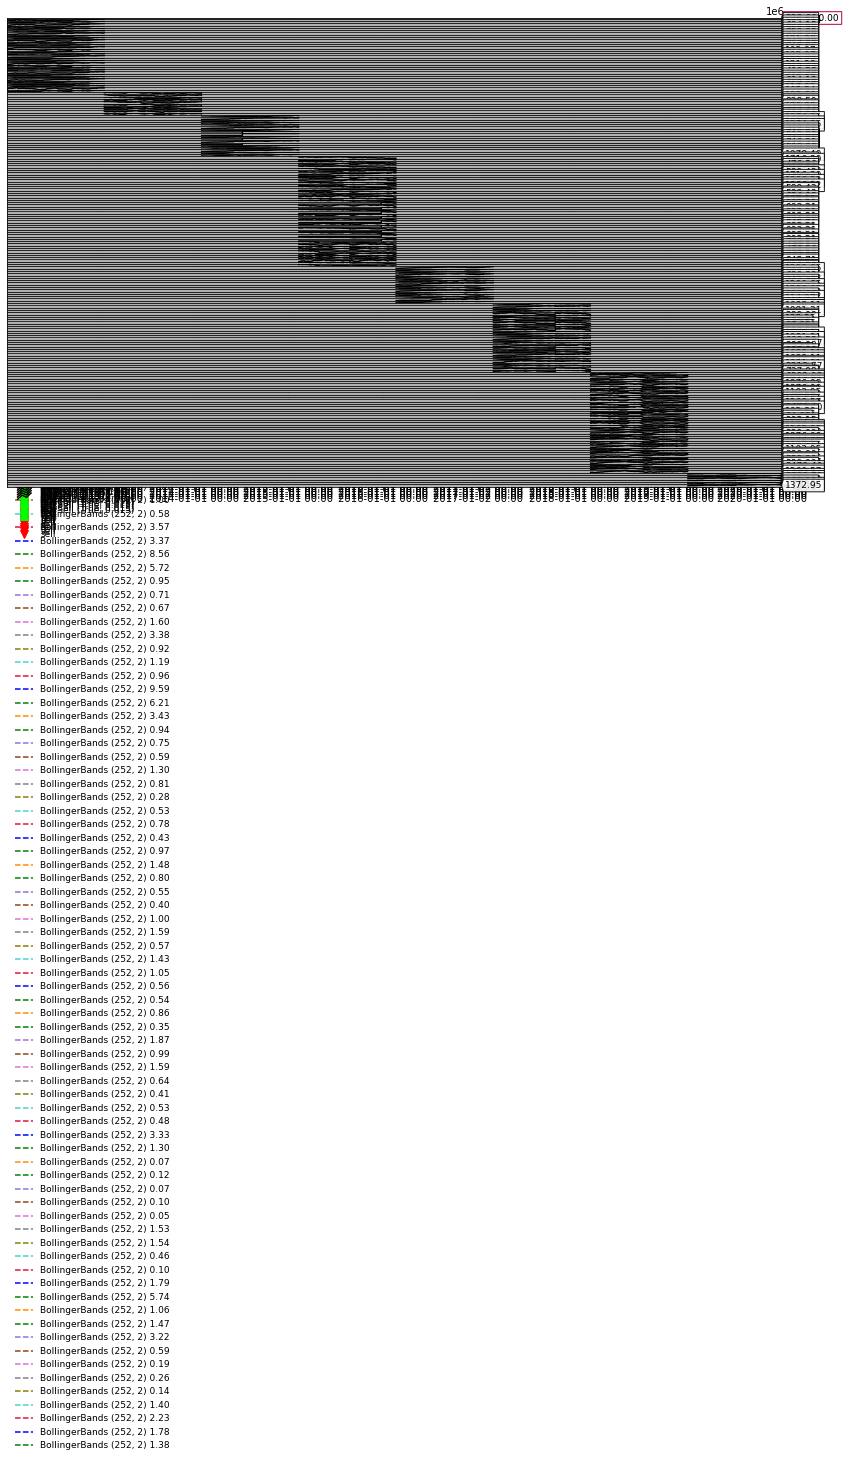

In [243]:
cerebro.plot()

In [176]:
test[0].analyzers.sharpe.get_analysis()

OrderedDict([('sharperatio', 0.28651311733061163)])